In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import math

In [2]:
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 1. Load the pretrained model

model= models.vgg19(pretrained=True)
model.to(device)
model.eval()

c:\Anaconda3\envs\models\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Anaconda3\envs\models\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# Flatten VGG into a list of layers
vgg_layers = []
for layer in model.features:
    vgg_layers.append(layer)
vgg_layers.append(model.avgpool)
vgg_layers.append(nn.Flatten())
for layer in model.classifier:
    vgg_layers.append(layer)


In [6]:
# 2. Utility: Load an Image from URL

def load_image_from_url(url):
    """Load an image from a URL and return it as a PIL Image."""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    return img

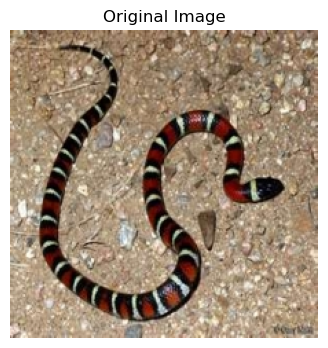

In [7]:
url = "https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/input_images/snake.png?raw=true"

try:
    img = load_image_from_url(url)
except Exception as e:
    print("Error loading image from URL:", e)
    print("Please replace 'url' with a working link or a local file path.")
    raise SystemExit

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

In [8]:
# Transform for images: resize, center-crop or direct resize, to Tensor,
# and normalize by ImageNet means/stdev

img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
         mean=[0.485, 0.456, 0.406],  
         std =[0.229, 0.224, 0.225]
    )
])

input_tensor = img_transform(img).unsqueeze(0).to(device)

print(input_tensor.shape)

torch.Size([1, 3, 224, 224])


In [9]:
# 3) FORWARD PASS: SAVE ACTIVATIONS


activations = [None]*len(vgg_layers)  # store forward outputs
relevances  = [None]*len(vgg_layers)  # store backward relevance

def forward_pass(model_layers, x):
    for i, layer in enumerate(model_layers):
        x = layer(x)
        activations[i] = x
    return x

In [17]:
def lrp_epsilon_rule(R_curr, layer, A_in, A_out, eps=1e-6):
    if isinstance(layer, nn.Linear):
        W = layer.weight
        b = layer.bias
        if A_in.dim() > 2:
            A_in_flat = A_in.view(A_in.size(0), -1)
        else:
            A_in_flat = A_in

        Z_ij = A_in_flat.mm(W.t()) + b
        sign_Z = torch.where(Z_ij >= 0, torch.tensor(1.0, device=Z_ij.device), torch.tensor(-1.0, device=Z_ij.device))
        Z_stable = Z_ij + eps * sign_Z

        xw = A_in_flat.unsqueeze(1) * W.unsqueeze(0)
        fraction = xw / (Z_stable.unsqueeze(-1) + 1e-9)
        R_in = (fraction * R_curr.unsqueeze(-1)).sum(dim=1)
        R_in = R_in.view_as(A_in)
        return R_in

    elif isinstance(layer, nn.Conv2d):
        if R_curr.dim() == 2:
            # Infer spatial dimensions from A_in (the input to this conv layer)
            if A_in.dim() == 4:
                b, c_in, h_in, w_in = A_in.shape
                # Calculate expected number of elements after flattening
                expected_size = c_in * h_in * w_in
                if R_curr.shape[1] != expected_size:
                    # If coming from a flattened layer, assume it matches the post-avgpool size
                    c_out = layer.out_channels
                    hw = R_curr.shape[1] // c_out
                    h = w = int(math.sqrt(hw))
                    if c_out * h * w == R_curr.shape[1]:
                        R_curr = R_curr.view(b, c_out, h, w)
                    else:
                        raise ValueError(f"Cannot reshape R_curr {R_curr.shape} to match conv layer expectations.")
                else:
                    R_curr = R_curr.view(b, c_in, h_in, w_in)

        W = layer.weight
        b = layer.bias
        stride = layer.stride
        padding = layer.padding

        Z_ = F.conv2d(A_in, W, bias=b, stride=stride, padding=padding)
        sign_Z = torch.where(Z_ >= 0, torch.tensor(1.0, device=Z_.device), torch.tensor(-1.0, device=Z_.device))
        Z_stable = Z_ + eps * sign_Z

        fraction = Z_ / (Z_stable + 1e-9)
        tmp = fraction * R_curr
        R_in = F.conv_transpose2d(tmp, W, bias=None, stride=stride, padding=padding)
        return R_in

    else:
        return R_curr

In [20]:
def lrp_backward(model_layers, eps=1e-6):
    # Create a temporary list to store the new relevances
    new_relevances = [None] * len(model_layers)
    new_relevances[-1] = relevances[-1]  # Start with the final relevance

    # Process layers in reverse order
    for i in reversed(range(len(model_layers))):
        layer = model_layers[i]
        R_curr = new_relevances[i]
        if R_curr is None:
            continue

        A_out = activations[i]
        A_in = input_tensor if i == 0 else activations[i - 1]

        # Debug: Print shapes to diagnose the issue
        print(f"Layer {i}: {layer.__class__.__name__}, R_curr shape: {R_curr.shape}, A_out shape: {A_out.shape}, A_in shape: {A_in.shape}")

        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            R_in = lrp_epsilon_rule(R_curr, layer, A_in, A_out, eps=eps)
        elif isinstance(layer, nn.ReLU):
            # R_curr should match A_out's shape (the output of this ReLU layer)
            if R_curr.shape != A_out.shape:
                raise ValueError(f"Shape mismatch at ReLU layer {i}: R_curr {R_curr.shape} does not match A_out {A_out.shape}")
            R_in = R_curr * (A_out > 0).float()
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            if i > 0 and R_curr.dim() == 4 and A_in.dim() == 4:
                h, w = A_in.shape[2], A_in.shape[3]
                R_in = F.interpolate(R_curr, size=(h, w), mode='nearest')
            else:
                R_in = R_curr
        elif isinstance(layer, nn.MaxPool2d):
            if i > 0 and R_curr.dim() == 4 and A_in.dim() == 4:
                R_in = F.interpolate(R_curr, size=A_in.shape[2:], mode='nearest')
            else:
                R_in = R_curr
        elif isinstance(layer, nn.Flatten):
            if i > 0 and R_curr.dim() == 2 and A_in.dim() == 4:
                b, c, h, w = A_in.shape
                if R_curr.shape[1] == c * h * w:
                    R_in = R_curr.view(b, c, h, w)
                else:
                    raise ValueError(f"Cannot reshape R_curr {R_curr.shape} to {A_in.shape}")
            else:
                R_in = R_curr
        else:
            R_in = R_curr

        # Store the new relevance for the previous layer
        if i > 0:
            if new_relevances[i - 1] is None:
                new_relevances[i - 1] = R_in
            else:
                new_relevances[i - 1] += R_in
        else:
            new_relevances[0] = R_in

    # Update the global relevances list after the loop
    for i in range(len(model_layers)):
        relevances[i] = new_relevances[i]

Predicted Class Index: 56,  Score=22.3084
Predicted Label: king snake
Layer 45: Linear, R_curr shape: torch.Size([1, 1000]), A_out shape: torch.Size([1, 1000]), A_in shape: torch.Size([1, 4096])
Layer 44: Dropout, R_curr shape: torch.Size([1, 4096]), A_out shape: torch.Size([1, 4096]), A_in shape: torch.Size([1, 4096])
Layer 43: ReLU, R_curr shape: torch.Size([1, 4096]), A_out shape: torch.Size([1, 4096]), A_in shape: torch.Size([1, 4096])
Layer 42: Linear, R_curr shape: torch.Size([1, 4096]), A_out shape: torch.Size([1, 4096]), A_in shape: torch.Size([1, 4096])
Layer 41: Dropout, R_curr shape: torch.Size([1, 4096]), A_out shape: torch.Size([1, 4096]), A_in shape: torch.Size([1, 4096])
Layer 40: ReLU, R_curr shape: torch.Size([1, 4096]), A_out shape: torch.Size([1, 4096]), A_in shape: torch.Size([1, 4096])
Layer 39: Linear, R_curr shape: torch.Size([1, 4096]), A_out shape: torch.Size([1, 4096]), A_in shape: torch.Size([1, 25088])
Layer 38: Flatten, R_curr shape: torch.Size([1, 25088]),

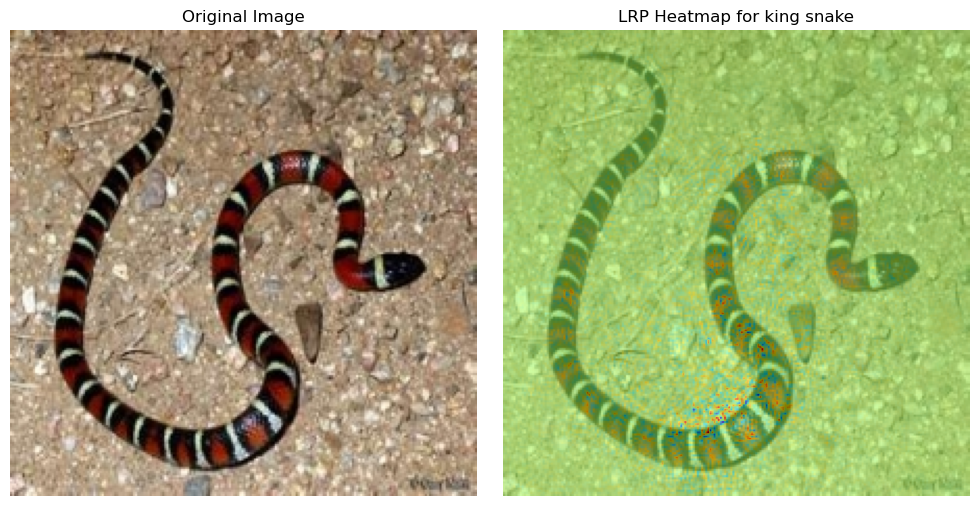

In [22]:
# Forward pass
with torch.no_grad():
    output = forward_pass(vgg_layers, input_tensor)
    pred_idx = output.argmax(dim=1).item()
    pred_val = output[0, pred_idx].item()

print(f"Predicted Class Index: {pred_idx},  Score={pred_val:.4f}")
print("Predicted Label:", classes[pred_idx])

# Initialize final relevance for the predicted class
relevances[-1] = torch.zeros_like(output)
relevances[-1][0, pred_idx] = output[0, pred_idx]

# Perform LRP
lrp_backward(vgg_layers, eps=1e-4)

# Extract and visualize heatmap
R_input = relevances[0]  # shape [1, C, H, W]
R_input_sum = R_input.sum(dim=1, keepdim=True)  # [1, 1, H, W]
heatmap = R_input_sum[0, 0].cpu().detach().numpy()

# Normalize 0..1
heatmap -= heatmap.min()
heatmap /= (heatmap.max() + 1e-9)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img.resize((224, 224)))
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f"LRP Heatmap for {classes[pred_idx]}")
plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
# Load MNIST dataset
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset_MNIST = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_MNIST)
test_dataset_MNIST = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_MNIST)

# Define train_loader_MNIST (this was missing)
train_loader_MNIST = torch.utils.data.DataLoader(dataset=train_dataset_MNIST, batch_size=64, shuffle=True)
test_loader_MNIST = torch.utils.data.DataLoader(dataset=test_dataset_MNIST, batch_size=1, shuffle=False)

In [29]:
# Define a simple CNN for MNIST
class SimpleCNN_MNIST(nn.Module):
    def __init__(self):
        super(SimpleCNN_MNIST, self).__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [30]:
# Instantiate and train the model
model_MNIST = SimpleCNN_MNIST().to(device)
optimizer_MNIST = torch.optim.Adam(model_MNIST.parameters(), lr=0.001)
criterion_MNIST = nn.CrossEntropyLoss()

In [32]:
# Training loop (updated to use train_loader_MNIST)
num_epochs_MNIST = 5  # Increased to 20 epochs as per your screenshot
model_MNIST.train()
for epoch in range(num_epochs_MNIST):
    for i, (images, labels) in enumerate(train_loader_MNIST):  # Use train_loader_MNIST
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_MNIST(images)
        loss = criterion_MNIST(outputs, labels)
        optimizer_MNIST.zero_grad()
        loss.backward()
        optimizer_MNIST.step()
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_MNIST}], Step [{i+1}/{len(train_loader_MNIST)}], Loss: {loss.item():.4f}')

model_MNIST.eval()
print("Training complete.")

Epoch [1/5], Step [100/938], Loss: 0.0031
Epoch [1/5], Step [200/938], Loss: 0.0041
Epoch [1/5], Step [300/938], Loss: 0.0301
Epoch [1/5], Step [400/938], Loss: 0.0258
Epoch [1/5], Step [500/938], Loss: 0.0159
Epoch [1/5], Step [600/938], Loss: 0.0230
Epoch [1/5], Step [700/938], Loss: 0.0017
Epoch [1/5], Step [800/938], Loss: 0.0018
Epoch [1/5], Step [900/938], Loss: 0.0004
Epoch [2/5], Step [100/938], Loss: 0.0004
Epoch [2/5], Step [200/938], Loss: 0.0007
Epoch [2/5], Step [300/938], Loss: 0.0006
Epoch [2/5], Step [400/938], Loss: 0.0047
Epoch [2/5], Step [500/938], Loss: 0.0019
Epoch [2/5], Step [600/938], Loss: 0.0099
Epoch [2/5], Step [700/938], Loss: 0.0053
Epoch [2/5], Step [800/938], Loss: 0.0011
Epoch [2/5], Step [900/938], Loss: 0.0919
Epoch [3/5], Step [100/938], Loss: 0.0042
Epoch [3/5], Step [200/938], Loss: 0.0630
Epoch [3/5], Step [300/938], Loss: 0.0024
Epoch [3/5], Step [400/938], Loss: 0.0491
Epoch [3/5], Step [500/938], Loss: 0.0008
Epoch [3/5], Step [600/938], Loss:

In [33]:
# Collect one image per digit (0-9) from the test set
images_per_digit = {}
test_iter_MNIST = iter(test_loader_MNIST)
while len(images_per_digit) < 10:
    images, labels = next(test_iter_MNIST)
    label = labels.item()
    if label not in images_per_digit:
        images_per_digit[label] = images.to(device)

# Global lists for MNIST
activations_MNIST = [None] * len(model_MNIST.layers)
relevances_MNIST = [None] * len(model_MNIST.layers)

In [34]:
# LRP functions (used for MNIST)
def lrp_epsilon_rule_MNIST(R_curr, layer, A_in, eps=1e-6):
    if isinstance(layer, nn.Linear):
        W = layer.weight
        b = layer.bias
        if A_in.dim() > 2:
            A_in_flat = A_in.view(A_in.size(0), -1)
        else:
            A_in_flat = A_in

        Z_ij = A_in_flat.mm(W.t()) + b
        sign_Z = torch.where(Z_ij >= 0, torch.tensor(1.0, device=Z_ij.device), torch.tensor(-1.0, device=Z_ij.device))
        Z_stable = Z_ij + eps * sign_Z

        xw = A_in_flat.unsqueeze(1) * W.unsqueeze(0)
        fraction = xw / (Z_stable.unsqueeze(-1) + 1e-9)
        R_in = (fraction * R_curr.unsqueeze(-1)).sum(dim=1)
        R_in = R_in.view_as(A_in)
        return R_in

    elif isinstance(layer, nn.Conv2d):
        if R_curr.dim() == 2:
            if A_in.dim() == 4:
                b, c_in, h_in, w_in = A_in.shape
                expected_size = c_in * h_in * w_in
                if R_curr.shape[1] != expected_size:
                    c_out = layer.out_channels
                    hw = R_curr.shape[1] // c_out
                    h = w = int(math.sqrt(hw))
                    if c_out * h * w == R_curr.shape[1]:
                        R_curr = R_curr.view(b, c_out, h, w)
                    else:
                        raise ValueError(f"Cannot reshape R_curr {R_curr.shape} to match conv layer expectations.")
                else:
                    R_curr = R_curr.view(b, c_in, h_in, w_in)

        W = layer.weight
        b = layer.bias
        stride = layer.stride
        padding = layer.padding

        Z_ = F.conv2d(A_in, W, bias=b, stride=stride, padding=padding)
        sign_Z = torch.where(Z_ >= 0, torch.tensor(1.0, device=Z_.device), torch.tensor(-1.0, device=Z_.device))
        Z_stable = Z_ + eps * sign_Z

        fraction = Z_ / (Z_stable + 1e-9)
        tmp = fraction * R_curr
        R_in = F.conv_transpose2d(tmp, W, bias=None, stride=stride, padding=padding)
        return R_in

    else:
        return R_curr

In [35]:
def forward_pass_MNIST(model_layers, input_tensor):
    x = input_tensor
    for i, layer in enumerate(model_layers):
        x = layer(x)
        activations_MNIST[i] = x
    return x

def lrp_backward_MNIST(model_layers, input_tensor_MNIST, eps=1e-6):
    new_relevances = [None] * len(model_layers)
    new_relevances[-1] = relevances_MNIST[-1]

    for i in reversed(range(len(model_layers))):
        layer = model_layers[i]
        R_curr = new_relevances[i]
        if R_curr is None:
            continue

        A_out = activations_MNIST[i]
        A_in = input_tensor_MNIST if i == 0 else activations_MNIST[i - 1]

        print(f"Layer {i}: {layer.__class__.__name__}, R_curr shape: {R_curr.shape}, A_out shape: {A_out.shape}, A_in shape: {A_in.shape}")

        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            R_in = lrp_epsilon_rule_MNIST(R_curr, layer, A_in, eps=eps)  # Updated function name and removed A_out
        elif isinstance(layer, nn.ReLU):
            if R_curr.shape != A_out.shape:
                raise ValueError(f"Shape mismatch at ReLU layer {i}: R_curr {R_curr.shape} does not match A_out {A_out.shape}")
            R_in = R_curr * (A_out > 0).float()
        elif isinstance(layer, nn.AdaptiveAvgPool2d):
            if i > 0 and R_curr.dim() == 4 and A_in.dim() == 4:
                h, w = A_in.shape[2], A_in.shape[3]
                R_in = F.interpolate(R_curr, size=(h, w), mode='nearest')
            else:
                R_in = R_curr
        elif isinstance(layer, nn.MaxPool2d):
            if i > 0 and R_curr.dim() == 4 and A_in.dim() == 4:
                R_in = F.interpolate(R_curr, size=A_in.shape[2:], mode='nearest')
            else:
                R_in = R_curr
        elif isinstance(layer, nn.Flatten):
            if i > 0 and R_curr.dim() == 2 and A_in.dim() == 4:
                b, c, h, w = A_in.shape
                if R_curr.shape[1] == c * h * w:
                    R_in = R_curr.view(b, c, h, w)
                else:
                    raise ValueError(f"Cannot reshape R_curr {R_curr.shape} to {A_in.shape}")
            else:
                R_in = R_curr
        else:
            R_in = R_curr

        if i > 0:
            if new_relevances[i - 1] is None:
                new_relevances[i - 1] = R_in
            else:
                new_relevances[i - 1] += R_in
        else:
            new_relevances[0] = R_in

    for i in range(len(model_layers)):
        relevances_MNIST[i] = new_relevances[i]

Layer 9: Linear, R_curr shape: torch.Size([1, 10]), A_out shape: torch.Size([1, 10]), A_in shape: torch.Size([1, 128])
Layer 8: ReLU, R_curr shape: torch.Size([1, 128]), A_out shape: torch.Size([1, 128]), A_in shape: torch.Size([1, 128])
Layer 7: Linear, R_curr shape: torch.Size([1, 128]), A_out shape: torch.Size([1, 128]), A_in shape: torch.Size([1, 1568])
Layer 6: Flatten, R_curr shape: torch.Size([1, 1568]), A_out shape: torch.Size([1, 1568]), A_in shape: torch.Size([1, 32, 7, 7])
Layer 5: MaxPool2d, R_curr shape: torch.Size([1, 32, 7, 7]), A_out shape: torch.Size([1, 32, 7, 7]), A_in shape: torch.Size([1, 32, 14, 14])
Layer 4: ReLU, R_curr shape: torch.Size([1, 32, 14, 14]), A_out shape: torch.Size([1, 32, 14, 14]), A_in shape: torch.Size([1, 32, 14, 14])
Layer 3: Conv2d, R_curr shape: torch.Size([1, 32, 14, 14]), A_out shape: torch.Size([1, 32, 14, 14]), A_in shape: torch.Size([1, 16, 14, 14])
Layer 2: MaxPool2d, R_curr shape: torch.Size([1, 16, 14, 14]), A_out shape: torch.Size([

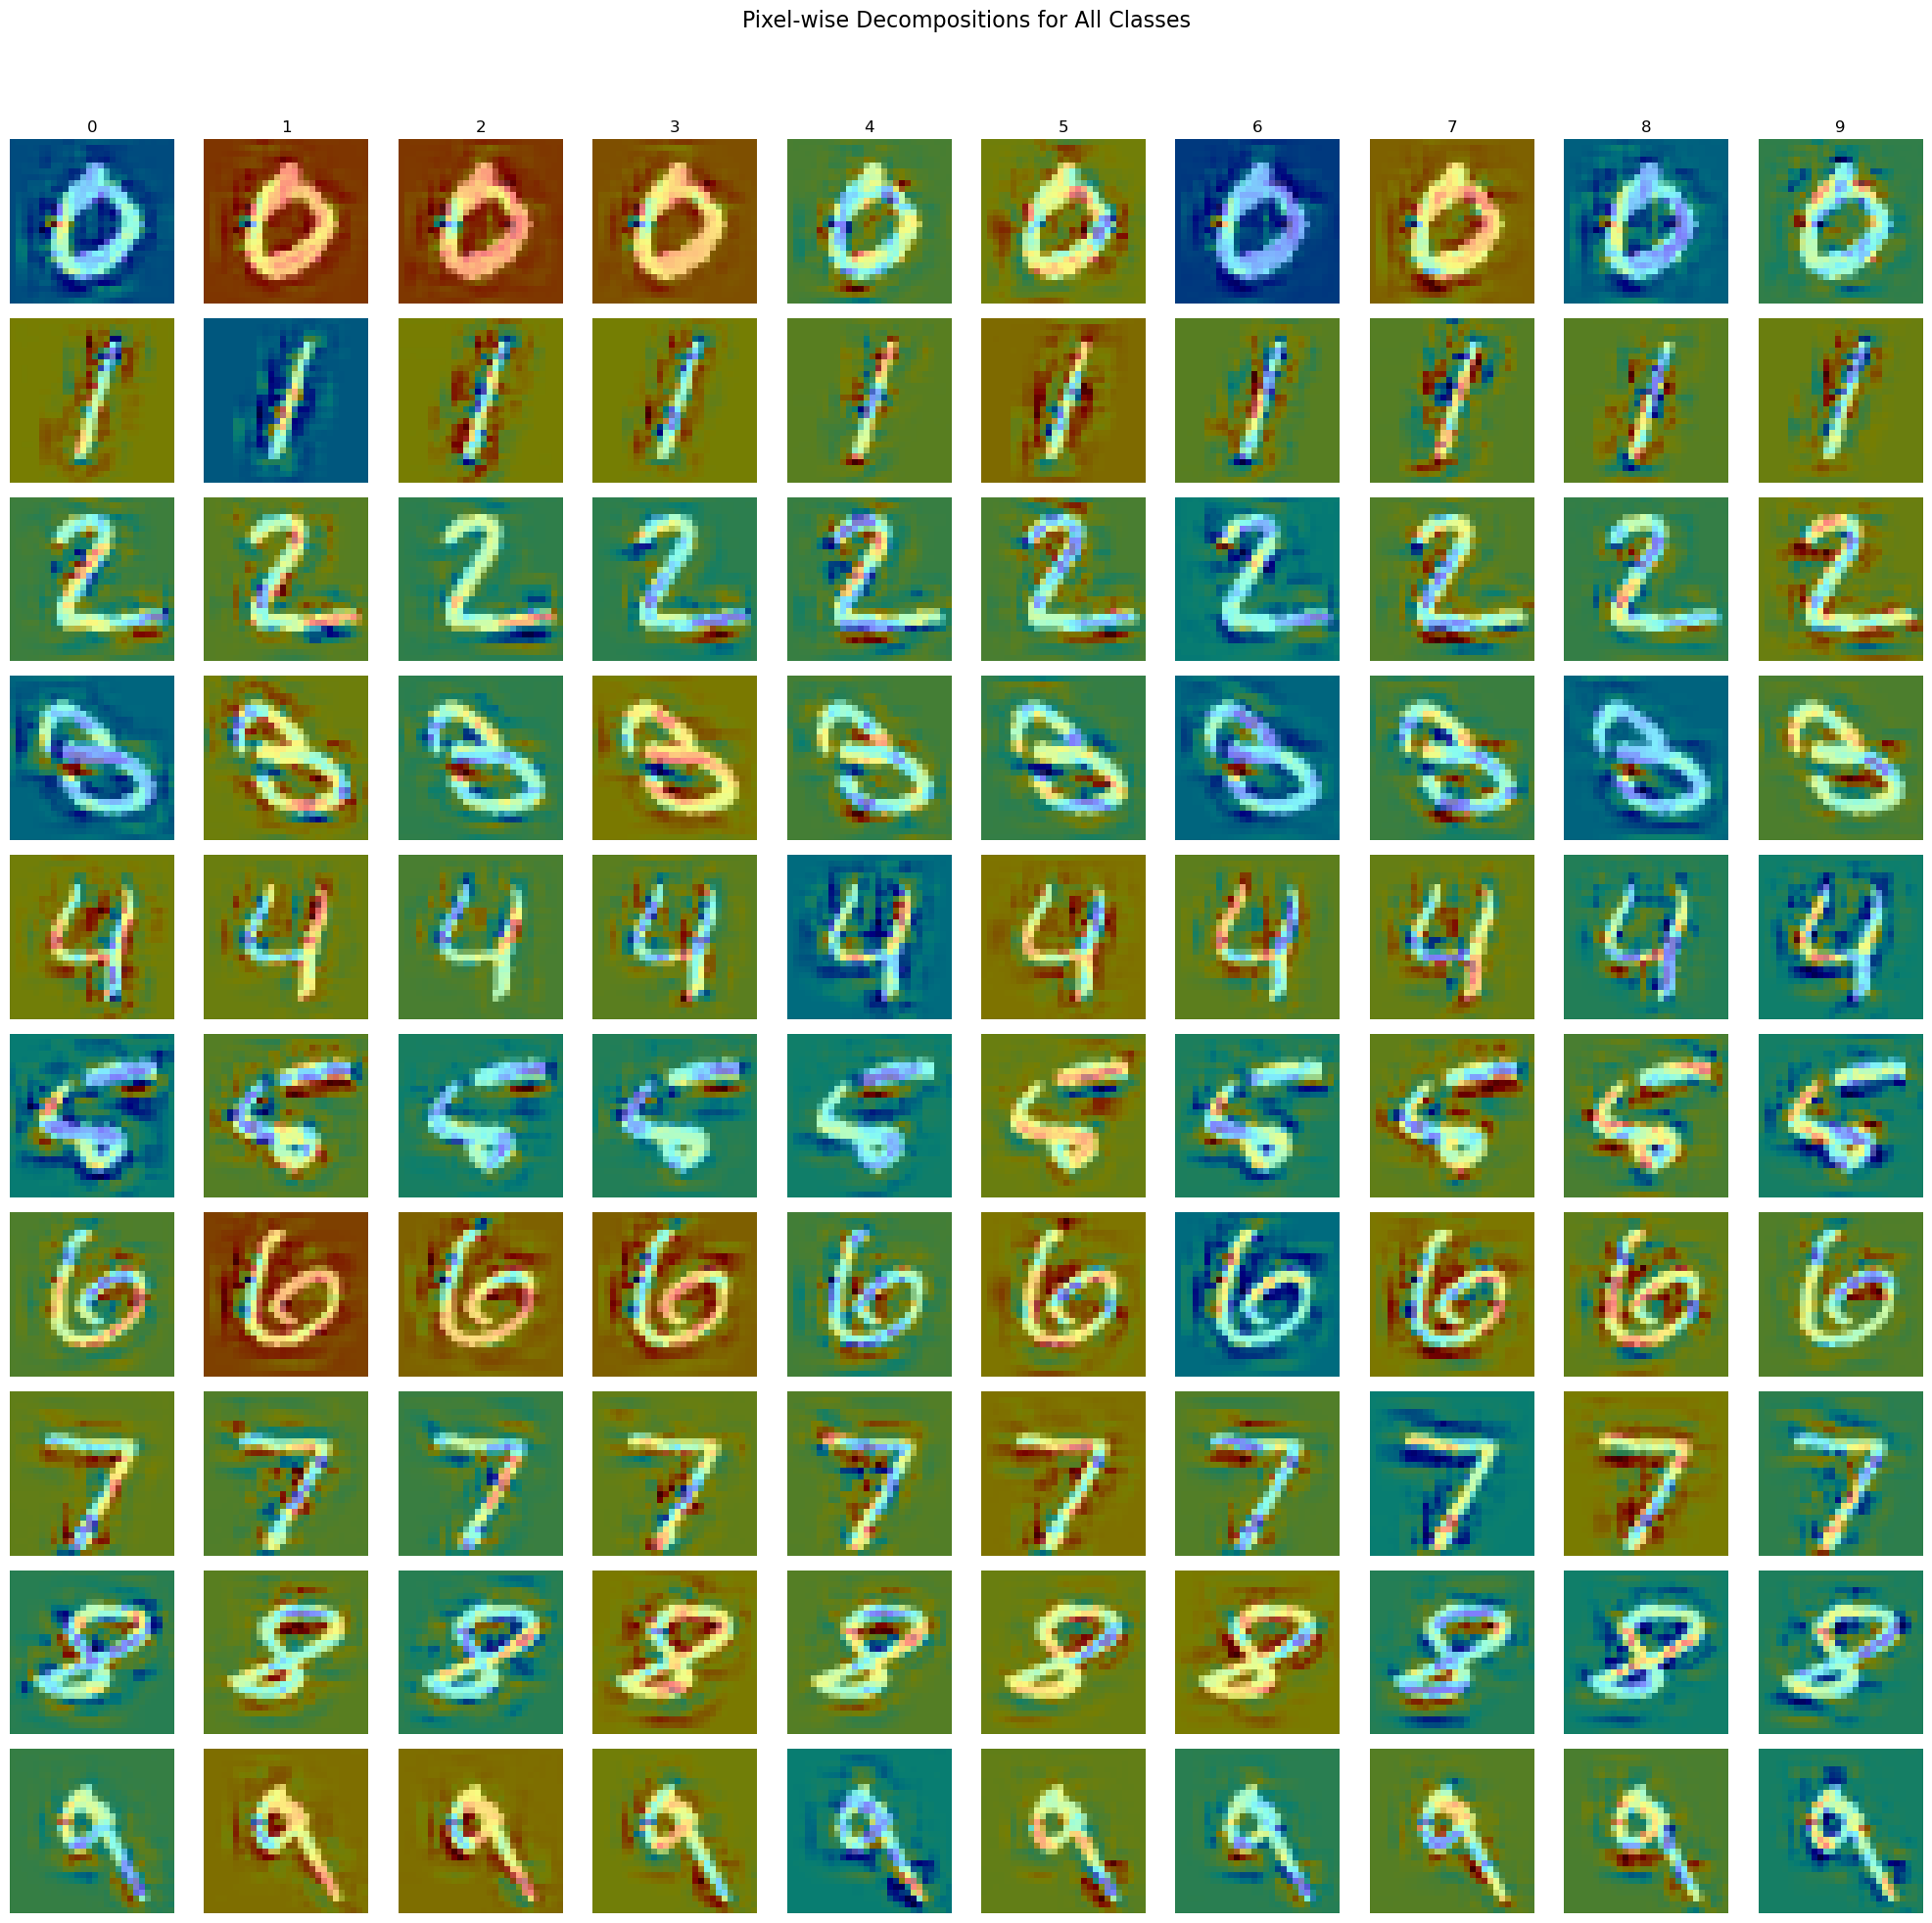

In [37]:
# Generate 10x10 heatmap grid
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

for true_label in range(10):
    # Get the image for this digit
    input_tensor_MNIST = images_per_digit[true_label]  # Shape: [1, 1, 28, 28]

    # Forward pass to get activations
    with torch.no_grad():
        output_MNIST = forward_pass_MNIST(model_MNIST.layers, input_tensor_MNIST)

    # Denormalize the image for visualization
    img_MNIST = input_tensor_MNIST[0, 0].cpu().numpy()
    img_MNIST = img_MNIST * 0.3081 + 0.1307
    img_MNIST = np.clip(img_MNIST, 0, 1)

    for pred_class in range(10):
        # Initialize relevance for this predicted class
        relevances_MNIST = [None] * len(model_MNIST.layers)
        relevances_MNIST[-1] = torch.zeros_like(output_MNIST)
        relevances_MNIST[-1][0, pred_class] = output_MNIST[0, pred_class]

        # Perform LRP
        lrp_backward_MNIST(model_MNIST.layers, input_tensor_MNIST, eps=1e-4)

        # Extract heatmap
        R_input_MNIST = relevances_MNIST[0]  # Shape: [1, 1, 28, 28]
        R_input_sum_MNIST = R_input_MNIST.sum(dim=1, keepdim=True)  # [1, 1, 28, 28]
        heatmap_MNIST = R_input_sum_MNIST[0, 0].cpu().detach().numpy()  # [28, 28]

        # Normalize heatmap
        heatmap_MNIST -= heatmap_MNIST.min()
        heatmap_MNIST /= (heatmap_MNIST.max() + 1e-9)

        # Plot the heatmap
        ax = axes[true_label, pred_class]
        ax.imshow(img_MNIST, cmap='gray')
        ax.imshow(heatmap_MNIST, cmap='jet', alpha=0.5)
        ax.axis('off')
        if true_label == 0:
            ax.set_title(f"{pred_class}")
        if pred_class == 0:
            ax.set_ylabel(f"{true_label}", fontsize=16, rotation=0, labelpad=20)

plt.suptitle("Pixel-wise Decompositions for All Classes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()